In [48]:
import json
from collections import Counter, defaultdict, deque
import gc

import numpy as np
import pandas as pd
import glob
import time
from tqdm import tqdm

from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sn

import lightgbm as lgb

import feather
import pickle
import h5py

from concurrent import futures
#import riiideducation

In [49]:
question = pd.read_csv("/home/pocket/input/questions.csv")
question.head(2)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81


<AxesSubplot:>

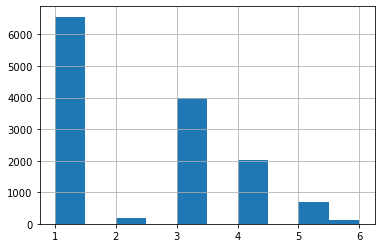

In [50]:
question["tags"].astype(str).apply(lambda x: len(x.split())).hist()

In [51]:
lecture = pd.read_csv("/home/pocket/input/lectures.csv")
lecture.head(2)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept


In [52]:
lecture = lecture.set_index("lecture_id")
lectures_dict = lecture.to_dict("index")

In [53]:
train = pd.read_feather("./train_sorted_full.feather")

In [54]:
train["prior_question_had_explanation"].fillna(False, inplace=True)

In [55]:
print(train.columns)

# no lectures for now
#train = train[train["answered_correctly"] != -1]

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation',
       'max_time_stamp', 'rand_time_stamp', 'virtual_time_stamp'],
      dtype='object')


In [56]:
class PocketCounter():
    def __init__(self):
        self.cnt = Counter()
        self.sum = Counter()
    
    def update(self, key, sum_val):
        self.cnt[key] += 1
        self.sum[key] += sum_val
        
    def get_mean(self, key):
        return (self.sum[key] / self.cnt[key]) if self.cnt[key] != 0 else np.nan

class PocketRoller():
    def __init__(self):
        self.roll = defaultdict(self.get_deq20)
    
    def update(self, key, val):
        self.roll[key].append(val)
        
    def get_deq20(self):
        return deque(maxlen=20)
    
    def get_mean(self, key):
        return sum(self.roll[key]) / len(self.roll[key]) if len(self.roll[key]) != 0 else np.nan

class PocketTimestamp():
    def __init__(self):
        self.prev_ts = {}
        self.prev_td = 0
        self.td = 0
    
    def update(self, key, ts):
        td = self.prev_ts.get(key, np.nan) - ts
        if td < 0 or np.isnan(td):
            self.td = td
            self.prev_td = td
        else:
            self.td = self.prev_td
        self.prev_ts[key] = ts
        
    def update_only_ts(self, key, ts):
        self.prev_ts[key] = ts
        
    def get_simple_td(self, key, ts):
        return self.prev_ts.get(key, np.nan) - ts
    

In [57]:
class PocketFeatureFactory():
    def __init__(self, is_train, contents_dict, lecture_dict):
        self.u_ac = PocketCounter()
        self.uc_ac = PocketCounter()
        self.ub_ac = PocketCounter()
        self.u_qm = PocketCounter()
        self.u_ac_roll = PocketRoller()
        self.u_ts = PocketTimestamp()
        self.uc_ts = PocketTimestamp()
        self.ub_ts = PocketTimestamp()
        self.u_ok_qm = PocketCounter()
        self.u_ng_qm = PocketCounter()
        self.up_ac = PocketCounter()
        self.ulr_ac = PocketCounter()
        self.uca_ac = PocketCounter()
        self.ut_ac = PocketCounter()
        self.ul_ts = PocketTimestamp()
        self.u_ts_wl = PocketTimestamp()
        
        self.lecture_dict = lecture_dict
        self.contents_dict = contents_dict
        self.is_train = is_train
        
    def get_row_tuple(self, row):
        ts, uid, cid, tcid = row[1], row[2], row[3], row[5]
        if self.is_train:
            et = row[8]
            pqhe = row[9]
        else:
            et = row[6]
            pqhe = row[7]
            
        return (ts, uid, cid, tcid, et, pqhe)
        
    def unpack_row(self, row):
        (ts, uid, cid, tcid, et, pqhe) = self.get_row_tuple(row)
        
        contents = self.contents_dict[cid]
        qm = contents["q_ac_mean"]
        bid = contents["bundle_id"]
        part = contents["part"]
        ca = contents["correct_answer"]
        lr = part < 5
        tags = contents["tags"].split()
        
        ucid = (uid, cid)
        utcid = (uid, tcid)
        ubid = (uid, bid)
        upid = (uid, part)
        ulr = (uid, lr)
        uca = (uid, ca)
        return (ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca)
    
    def do_lecture(self, row):
        ts, uid, cid = row[1], row[2], row[3]
        self.ul_ts.update_only_ts(uid, ts)
        self.u_ts_wl.update_only_ts(uid, ts)
    
    def update_ac_values(self, prev_rows, prev_acs, prev_uas):
        for i, row in enumerate(prev_rows):
            self.update_ac_value(row, prev_acs[i], prev_uas[i])
    
    def update_ac_value(self, row, prev_ac, prev_ua):
        ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca = self.unpack_row(row)
        
        self.u_ac.update(uid, prev_ac)
        self.uc_ac.update(ucid, prev_ac)
        self.ub_ac.update(ubid, prev_ac)
        self.up_ac.update(upid, prev_ac)
        self.ulr_ac.update(ulr, prev_ac)
        self.uca_ac.update(uca, prev_ac)
        self.u_ac_roll.update(uid, prev_ac)

        for tag in tags:
            ut = (uid, tag)
            self.ut_ac.update(ut, prev_ac)

        if prev_ac > 0.5:
            self.u_ok_qm.update(uid, qm)
        else:
            self.u_ng_qm.update(uid, qm)

    def make_row(self, row, data_list):
        ts, uid, cid, tcid, et, pqhe, qm, tags, ucid, utcid, ubid, upid, ulr, uca = self.unpack_row(row)

        output = {}
        if self.is_train:
            output["ac"] = row[7]
        output["et"] = et
        
        contents = self.contents_dict[cid]
        content_col = [
            "q_ac_mean", "q_ac_cnt", "q_et_mean", "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt",
            "part", "correct_answer",
            "q_ok_uac_mean", "q_ok_uac_std", "q_ng_uac_mean", "q_ng_uac_std",
            "q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
        ]
        for c in content_col:
            output[c] = contents[c]
            
        self.u_ts.update(uid, ts)
        self.ub_ts.update(ubid, ts)
        self.uc_ts.update(ucid, ts)
        self.u_ts_wl.update(uid, ts)
        output["u_td"] = self.u_ts.td
        output["ub_td"] = self.ub_ts.td
        output["uc_td"] = self.uc_ts.td
        output["u_td_wl"] = self.u_ts_wl.td
        output["ul_td"] = self.ul_ts.get_simple_td(uid, ts)

        self.u_qm.update(uid, qm)
        output["u_cnt"] = self.u_qm.cnt[uid]
        output["u_ac_cnt"] = self.u_ac.cnt[uid]
        output["u_ac_mean"] = self.u_ac.get_mean(uid)
        output["uc_ac_cnt"] = self.uc_ac.cnt[ucid]
        output["uc_ac_mean"] = self.uc_ac.get_mean(ucid)
        output["ub_ac_cnt"] = self.ub_ac.cnt[ubid]
        output["ub_ac_mean"] = self.ub_ac.get_mean(ubid)
        output["uca_ac_cnt"] = self.uca_ac.cnt[uca]
        output["uca_ac_mean"] = self.uca_ac.get_mean(uca)
        output["u_qm_mean"] = self.u_qm.get_mean(uid)
        output["up_ac_cnt"] = self.up_ac.cnt[upid]
        output["up_ac_mean"] = self.up_ac.get_mean(upid)
        output["ulr_ac_mean"] = self.ulr_ac.get_mean(ulr)
        output["u_ok_qm_mean"] = self.u_ok_qm.get_mean(uid)
        output["u_ng_qm_mean"] = self.u_ng_qm.get_mean(uid)
        
        output["u_ac_mean20"] = self.u_ac_roll.get_mean(uid)
        
        ut_sum = 0
        ut_cnt = 0
        ut_mean = []
        for tag in tags:
            ut = (uid, tag)
            ut_sum += self.ut_ac.sum[ut]
            ut_cnt += self.ut_ac.cnt[ut]
            if self.ut_ac.cnt[ut] != 0:
                ut_mean.append(self.ut_ac.get_mean(ut))
        output["ut_ac_mean"] = (ut_sum / ut_cnt) if ut_cnt != 0 else np.nan
        output["ut_ac_mean2"] = sum(ut_mean) / len(ut_mean) if len(ut_mean) != 0 else np.nan

        data_list.append(output)
        return data_list


In [72]:
class PocketFFUtil():
    def __init__(self):
        pass
    
    def merge(self, ff1, ff2):
        counters = [
            "u_ac", "uc_ac", "ub_ac", "u_qm", "u_ok_qm", "u_ng_qm",
            "up_ac", "ulr_ac", "uca_ac", "ut_ac"
        ]
        for counter in counters:
            c1 = getattr(ff1, counter)
            c2 = getattr(ff2, counter)
            c1.cnt.update(c2.cnt)
            c1.sum.update(c2.sum)
        
        timestamps = [
            "u_ts", "uc_ts", "ub_ts", "ul_ts", "u_ts_wl"
        ]
        for timestamp in timestamps:
            ts1 = getattr(ff1, timestamp)
            ts2 = getattr(ff2, timestamp)
            ts1.prev_ts.update(ts2.prev_ts)
        
        rolls = ["u_ac_roll"]
        for r in rolls:
            r1 =  getattr(ff1, r)
            r2 =  getattr(ff2, r)
            r1.roll.update(r2.roll)
        return ff1
    
    def to_csv(self, ff):
        uid_set, ub_dict, uc_dict = self.make_ins_dict(ff)
        
        with h5py.File("ub_dict_1210.hdf5", "w") as f:
            for (uid, l) in tqdm(ub_dict.items()):
                f.create_dataset(str(uid), data=l)
        
        with h5py.File("uc_dict_1210.hdf5", "w") as f:   
            for (uid, l) in tqdm(uc_dict.items()):
                f.create_dataset(str(uid), data=l)
                
        with open("./uid_set_1210.pkl", "wb") as handle:
            pickle.dump(uid_set, handle, pickle.HIGHEST_PROTOCOL)
        
        ff = self.del_filed_attributes(ff)
        with open("./ff_1210.pkl", "wb") as handle:
            pickle.dump(ff, handle, pickle.HIGHEST_PROTOCOL)
            
    def make_ins_dict(self, ff):
        uid_set = set()
        ub_dict, uc_dict = {}, {}
        #print(len(ff.ub_ac), len(ff.ub_ts), len(ff.uc_ac), len(ff.uc_ts))
        
        for k, ts in tqdm(ff.ub_ts.prev_ts.items()):
            (uid, bid) = k
            l = ub_dict.get(uid, [])
            ac_sum, ac_cnt = ff.ub_ac.sum.get(k, np.nan), ff.ub_ac.cnt.get(k, np.nan)
            new_data = [bid, ts, ac_sum, ac_cnt]
            l.append(new_data)
            ub_dict[uid] = l
            uid_set.add(uid)
        for k, ts in tqdm(ff.uc_ts.prev_ts.items()):
            (uid, cid) = k
            l = uc_dict.get(uid, [])
            ac_sum, ac_cnt = ff.uc_ac.sum.get(k, np.nan), ff.uc_ac.cnt.get(k, np.nan)
            new_data = [cid, ts, ac_sum, ac_cnt]
            l.append(new_data)
            uc_dict[uid] = l
            uid_set.add(uid)
        return uid_set, ub_dict, uc_dict
    
    def del_filed_attributes(self, ff):
        ff.ub_ac = PocketCounter()
        ff.ub_ts = PocketTimestamp()
        ff.uc_ac = PocketCounter()
        ff.uc_ts = PocketTimestamp()
        return ff
        

In [59]:
# content_train = train[:50*1000*1000].copy()
# train = train[50*1000*1000:]


# q_col = ["question_id", "bundle_id"]
# content_train = pd.merge(
#     content_train, question[q_col], left_on="content_id", right_on="question_id", how="left"
# )

# # contents features
# # there are no new contents in the test, so we use part of the train as the pseudo-training set
# temp = content_train.groupby("content_id")["answered_correctly"].agg(["mean", "count"])
# temp.columns = ["q_ac_mean", "q_ac_cnt"]
# temp2 = content_train.groupby("content_id")["prior_question_elapsed_time"].agg(["mean", "count", "std"])
# temp2.columns = ["q_et_mean", "q_et_cnt", "q_et_std"]
# # temp3 = content_train.groupby("content_id")["timestamp_diff"].agg(["mean", "std", "min", "max", "skew"])
# # temp3.columns = ["q_td_mean", "q_td_std", "q_td_min", "q_td_max", "q_td_skew"]
# temp4 = content_train.groupby("bundle_id")["answered_correctly"].agg(["mean", "count"])
# temp4.columns = ["b_ac_mean", "b_ac_cnt"]
# q_col = ["question_id", "bundle_id", "part"]
# #q_col += [str(i) for i in range(188)]
# contents = pd.merge(question[q_col], temp, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp2, left_on="question_id", right_on="content_id", how="left")
# #contents = pd.merge(contents, temp3, left_on="question_id", right_on="content_id", how="left")
# contents = pd.merge(contents, temp4, on="bundle_id", how="left")
# print(contents.head(2))
# print(contents.shape)
# merge_col = [
#     "question_id", "q_ac_mean", "q_ac_cnt", "q_et_mean",
#     "q_et_cnt", "q_et_std", "b_ac_mean", "b_ac_cnt"
# ]
# contents = contents[merge_col]
# contents = contents.set_index("question_id")
# contents_dict = contents.to_dict("index")
# print(len(contents_dict))

In [60]:
# with open("./contents_dict.pkl", "wb") as handle:
#     pickle.dump(contents_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(len(contents_dict))

In [61]:
with open("./contents_dict_full_1208.pkl", "rb") as handle:
    contents_dict = pickle.load(handle)
print(len(contents_dict))

13523


In [62]:
# cnt = 0
# for k, v in contents_dict.items():
#     try:
#         v["tags"].split()
#         cnt += 1
#     except Exception:
#         print(v["tags"])
#         print(cnt)
    

In [63]:
#content_train = train[:50*1000*1000].copy()
#train = train[50*1000*1000:]

In [64]:
print(len(train))

101230332


In [65]:
class SingleLgb:
    def __init__(self, seed=99, dry_run=False):
        self.train_param = self.get_param()
        if dry_run:
            self.num_rounds = 100
        else:
            self.num_rounds = 500

    def do_train_direct(self, x_train, x_test, y_train, y_test):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_test, y_test)

        # print('Start training...')
        model = lgb.train(self.train_param,
                          lgb_train,
                          valid_sets=[lgb_eval],
                          verbose_eval=100,
                          num_boost_round=self.num_rounds,
                          early_stopping_rounds=100,
                          #categorical_feature=[]
                         )
        # print('End training...')
        return model

    @staticmethod
    def show_feature_importance(model, filename=None):
        fi = pd.DataFrame({
            "name": model.feature_name(),
            "importance_split": model.feature_importance(importance_type="split").astype(int),
            "importance_gain": model.feature_importance(importance_type="gain").astype(int),
        })
        fi = fi.sort_values(by="importance_gain", ascending=False)
        print(fi)
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            #print(df)

    @staticmethod
    def get_param():
        return {
            'num_leaves': 127,
            'min_data_in_leaf': 100,
            'objective': 'binary',
            #'metric': 'auc',
            'metric': 'binary_logloss',
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting": "gbdt",
            "feature_fraction": 0.9,
            "verbosity": -1,
            "random_state": 81,
        }
    
class SingleTrainer:
    def __init__(self, pred_col, dry_run=False):
        self.pred_col = pred_col
        self.target_col = "ac"
        self.dry_run = dry_run
        self.val_size = 4*1000*1000

    def train_model(self, df):
        X = df[self.pred_col]
        y = df[self.target_col]
        
        models, scores = list(), list()
        for fold in range(4):
            print("---------")
            print("fold=", fold)
            f, c = fold, self.val_size
            val_s, val_e = -c-f*c, len(df)-f*c
            train_idx = -c-f*c
            X_train, X_val = X.iloc[:train_idx], X.iloc[val_s:val_e]
            y_train, y_val = y.iloc[:train_idx], y.iloc[val_s:val_e]
            print(X_train.shape, X_val.shape)
            
            lgbm = SingleLgb(seed=99, dry_run=self.dry_run)
            model = lgbm.do_train_direct(X_train, X_val, y_train, y_val)
            score = model.best_score["valid_0"]["binary_logloss"]
            pred = model.predict(X_val)
            score = metrics.roc_auc_score(y_val, pred)
            print("AUC=", score)
            if fold == 0:
                lgbm.show_feature_importance(model)
            models.append(model)
            scores.append(score)
            break
        return models, np.mean(scores)

In [66]:
# train_data_list = list()
# utcid_set = set()
# prev_rows, prev_acs, prev_uas = list(), list(), list()
# #init_values()

# not_updated_idx = 0
# for i, row in enumerate(tqdm(train.values)):
# #     if i < 56597670:
# #         continue
# #     if i > 56597680:
# #         break
#     uid = row[2]
#     tcid = row[5]
#     utcid = (uid, tcid)
#     if utcid not in utcid_set:
#         if len(prev_rows) > 0:
#             update_ac_values(prev_rows, prev_acs, prev_uas)
#             prev_rows.clear()
#             prev_acs.clear()
#             prev_uas.clear()
#             utcid_set.clear()
#             not_updated_idx = i
#     prev_rows.append(row)
#     prev_acs.append(row[7])
#     prev_uas.append(row[6])
#     utcid_set.add(utcid)
        
#     make_row(row, train_data_list, True)
        

# start_time = time.time()
# df = pd.DataFrame(train_data_list)
# end_time = time.time()
# print(end_time - start_time)
# print(df.head(2))
# #print(df.info())

In [67]:
def get_row(train_):
    ff = PocketFeatureFactory(True, contents_dict, lectures_dict)
    train_data_list = list()
    utcid_set = set()
    prev_rows, prev_acs, prev_uas = list(), list(), list()

    for i, row in enumerate(train_.values):
        ctype = row[4]
        if ctype == 1:
            ff.do_lecture(row)
            continue
        uid = row[2]
        tcid = row[5]
        utcid = (uid, tcid)
        if utcid not in utcid_set:
            if len(prev_rows) > 0:
                #prev_df2 = train.iloc[not_updated_idx:i] iloc too slow lol
                ff.update_ac_values(prev_rows, prev_acs, prev_uas)
                prev_rows.clear()
                prev_acs.clear()
                prev_uas.clear()
                utcid_set.clear()
                
        prev_rows.append(row)
        prev_acs.append(row[7])
        prev_uas.append(row[6])
        utcid_set.add(utcid)

        ff.make_row(row, train_data_list)
    ff.update_ac_values(prev_rows, prev_acs, prev_uas)
    
    #return train_data_list
    ret_df = pd.DataFrame(train_data_list)
    return ret_df, ff

start_time = time.time()
SPLIT_NUM = 16
USE_FROM = 7

# train["uid_mod"] = train["user_id"] % (USE_FROM)
# train = train[train["uid_mod"] == 0]
# print(len(train))

train["uid_mod"] = train["user_id"] % (SPLIT_NUM)
split_series = list()
for i in range(0, SPLIT_NUM):
    one_split = train[train["uid_mod"] == i]
    split_series.append(one_split)

future_list = list()
with futures.ProcessPoolExecutor(max_workers=SPLIT_NUM) as executor:
    for s in split_series:
        future_list.append(executor.submit(get_row, s))
future_results = [f.result() for f in future_list]
end_time = time.time()
print(end_time - start_time)
df_futures = [f[0] for f in future_results]
ff_futures = [f[1] for f in future_results]
df = pd.concat(df_futures)
# future_results = []
# for f in future_list:
#     future_results += f.result()
# df = pd.DataFrame(future_results)
print(df.shape)
end_time = time.time()
print(end_time - start_time)

14553671
116.79376292228699
(14268693, 42)
123.01927757263184


In [68]:
utils = PocketFFUtil()
conc_ff = ff_futures[0]
for i in range(len(ff_futures)-1):
    conc_ff = utils.merge(conc_ff, ff_futures[i+1])
    

In [69]:
print(len(conc_ff.u_ts.prev_ts.keys()))
print(len(conc_ff.uc_ts.prev_ts.keys()))
print(len(conc_ff.ub_ts.prev_ts.keys()))
print(len(conc_ff.u_ac.cnt.keys()))
print(len(conc_ff.uc_ac.cnt.keys()))
print(len(conc_ff.ub_ac.cnt.keys()))

55943
12438114
9499991
55943
12438085
9499975


In [70]:
print(train["user_id"].nunique())

55943


In [73]:
utils = PocketFFUtil()
utils.to_csv(conc_ff)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [ ]:
# del train_data_list
# gc.collect()

In [ ]:
print("hi")

In [ ]:
# %%timeit
# df = pd.DataFrame(data_list)
# 24.7 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [75]:
df.head(2)

,ac,et,q_ac_mean,q_ac_cnt,q_et_mean,q_et_cnt,q_et_std,b_ac_mean,b_ac_cnt,part,...,uca_ac_mean,u_qm_mean,up_ac_cnt,up_ac_mean,ulr_ac_mean,u_ok_qm_mean,u_ng_qm_mean,u_ac_mean20,ut_ac_mean,ut_ac_mean2
0,1,NaN,0.966869,19619,23471.402344,5406,16817.431721,0.966869,19619,1,...,NaN,0.966869,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,10000.0,0.954815,21733,19462.746094,21732,10070.528940,0.954815,21733,1,...,1.0,0.960842,1,1.0,1.0,0.966869,NaN,1.0,1.0,1.0


In [76]:
#df.to_feather("./temp_df.feather")

In [77]:
df.columns

Index(['ac', 'et', 'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt',
       'q_et_std', 'b_ac_mean', 'b_ac_cnt', 'part', 'correct_answer',
       'q_ok_uac_mean', 'q_ok_uac_std', 'q_ng_uac_mean', 'q_ng_uac_std',
       'q_pqhe_true_uac_mean', 'q_pqhe_true_uac_std', 'q_pqhe_false_uac_mean',
       'q_pqhe_false_uac_std', 'u_td', 'ub_td', 'uc_td', 'u_td_wl', 'ul_td',
       'u_cnt', 'u_ac_cnt', 'u_ac_mean', 'uc_ac_cnt', 'uc_ac_mean',
       'ub_ac_cnt', 'ub_ac_mean', 'uca_ac_cnt', 'uca_ac_mean', 'u_qm_mean',
       'up_ac_cnt', 'up_ac_mean', 'ulr_ac_mean', 'u_ok_qm_mean',
       'u_ng_qm_mean', 'u_ac_mean20', 'ut_ac_mean', 'ut_ac_mean2'],
      dtype='object')

In [78]:
#df = pd.read_feather("./temp_df.feather")

In [79]:

pred_col = [
    "et", "q_ac_mean", "q_ac_cnt",  'b_ac_mean', 'b_ac_cnt',
    "u_ac_mean", "u_cnt", "u_qm_mean", #"u_td", #"uc_td",
    "u_ac_cnt", #"u_et_cnt"
    #"u_et_mean", "u_prev_qm", small gain
#     "part", "ts",
    'u_ok_qm_mean', 'u_ng_qm_mean',
    'q_et_mean', 'q_et_cnt', 'q_et_std',
    #"ub_td",
    # "ubb_cnt", 
    "ub_ac_cnt",
   "up_ac_cnt", "up_ac_mean",
    "u_td", "ub_td",
    "q_ng_uac_mean","q_ok_uac_mean", 
     #"q_uac_mean", "q_uac_std", "q_ok_uac_std",  "q_ng_uac_mean","q_ng_uac_std",
    #"tcid" #uca_ac_cnt", "uca_ac_mean"
    "correct_answer",
    "u_ac_mean20",
    #"u_qm_roll20"
    #"u_ac_10070", "u_ac_7050", "u_ac_500", "u_ac_700"
    #"uid", "cid"
#     "u_qm70_cnt", "u_qm50_cnt", "u_qm30_cnt",
#     "u_qm70_ratio", "u_qm50_ratio", "u_qm30_ratio"
    "ulr_ac_mean", #"ulr_ac_cnt",  "ub_cnt",
    #"utd_mean", "b_cnt", "b_done_ratio", "uca_ac_cnt", "uca_ac_mean",
    #"ubb_cnt_rev", "ut_ac_mean", #"ut_ac_mean2"
    "ut_ac_mean", "uca_ac_mean", "ut_ac_mean2",
    "u_td_wl", "ul_td", 
    "q_pqhe_true_uac_mean", "q_pqhe_true_uac_std", "q_pqhe_false_uac_mean", "q_pqhe_false_uac_std",
    #"pqhe",
    "uc_td", "uc_ac_mean", #"uc_ac_cnt", 
    "ub_ac_mean", #"ub_ac_cnt"
]

In [ ]:
light_col = [
    'q_ac_mean', 'q_ac_cnt', 'q_et_mean', 'q_et_cnt', 'q_et_std', 'b_ac_mean', 'b_ac_cnt',
    'u_cnt', 'u_qm_mean', 'u_ac_mean', 'et', "ub_td2"
]
new_light_col = [
    'u_ok_qm_mean', 'u_ng_qm_mean',
    "up_ac_mean", "uca_ac_mean", #"u_ac_mean20", 
    #"ut_ac_mean", "ut_ac_mean2",
    "q_ng_uac_mean","q_ok_uac_mean", 
    "u_td2", 
    #"ub_cnt", "ubb_cnt",
    #"up_ac_cnt", "u_ac_cnt",
    "correct_answer", "ulr_ac_mean"
]
pred_col = light_col + new_light_col

In [ ]:
# show_col = ["ub_td2"]
# df[show_col].describe()
#min=-8.655624e+12

In [ ]:
# df["ub_td_z"] = df["ub_td2"]//10*1000

In [80]:
#temp_df = df[1*1000*1000:].copy()
#temp_df = df.copy()
trainer = SingleTrainer(pred_col, dry_run=False)
models, score = trainer.train_model(df)

---------
fold= 0
(10268693, 36) (4000000, 36)
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.519658
[200]	valid_0's binary_logloss: 0.51826
[300]	valid_0's binary_logloss: 0.517644
[400]	valid_0's binary_logloss: 0.517233
[500]	valid_0's binary_logloss: 0.51702
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.51702
AUC= 0.7876263537420607
                     name  importance_split  importance_gain
1               q_ac_mean              2467          7123327
5               u_ac_mean              2488          1053132
33                  uc_td               985           701814
16             up_ac_mean              2239           680746
10           u_ng_qm_mean              3017           623282
23            ulr_ac_mean              1997           496788
3               b_ac_mean              1401           479338
27                u_td_wl              3025           440082
19          q_ng_uac_mean  

In [ ]:
#standard way
#[1000]	valid_0's auc: 0.782993

#periodic initialization
#0.730-2

#with u_ac_mean
#0.762

#with uc_td
#has 0.776ish

#with U_et_cnt(reset-cnt)
#same

#with uc_ac_prev
#0.777ish

#without
#[1000]	valid_0's auc: 0.765165

# with full row  feature
#[1000]	valid_0's auc: 0.765111

# with full cdict
#[1000]	valid_0's auc: 0.765448

# dropping td by //10*1000 decrease score by 0.001

# new feats from test_features=0.785 ->?0.7897

print("done")

In [ ]:
models[0].save_model("./model.lgb")